In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import tensorflow as tf
import h5py
import numpy as np
import pandas as pd
import os
import scipy.stats as ss
import src
from src.transfer_learn import KinnLayer, amber_app
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

Using TensorFlow backend.


In [3]:
target_wd = "outputs/2022-11-01/TL_1"
#target_wd = "outputs/test_tl_amber"
#target_wd = "outputs/2022-10-28/bak_TL3_745"

In [4]:
if os.path.isdir("weights"):
    os.rmdir("weights")
amb = amber_app(wd=".", run=False)
# clean up folders created by trainEnv
os.rmdir("weights")

BUILDING
----------


2022-11-01 21:51:34,660 - AMBER - INFO -
 time budget set to: 72:00:00


controller = GeneralController
modeler = <class 'src.transfer_learn.TransferKinnModelBuilder'>
knowledge = zero
reward = LossAucReward
manager = GeneralManager
env_type = ControllerTrainEnv


In [5]:
# optionally, load model space from disk
#%run src/transfer_learn
#with open(os.path.join(target_wd, "model_space.pkl"), "rb") as f:
#    model_space, _ = pickle.load(f)
#amb.model_fn.model_space = model_space
#amb.model_space = model_space

In [6]:
enable_load = True

if enable_load is True:
    train_hist = pd.read_table(os.path.join(target_wd, "train_history.csv"), sep=",", header=None)
    best_trial_id = train_hist.sort_values(2, ascending=False).head(1)[0]
    best_arc_seq = train_hist.loc[best_trial_id, 3:].iloc[0].tolist()
    # loading from h5 is not working yet
    # AttributeError: 'str' object has no attribute 'Layer_type'
    #model = tf.keras.models.load_model(
    #    os.path.join(target_wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"),
    #    custom_objects={
    #        "KinnLayer": amb.model_fn.custom_objects['kinnlayer'],
    #        "InceptionLayer": amb.model_fn.custom_objects['inceptionlayer'],
    #        "AttentionPooling": amb.model_fn.custom_objects['attentionpooling'],
    #        "Bidirectional": amb.model_fn.custom_objects['bidirectional'],
    #    })
    print(train_hist.loc[best_trial_id])
else:
    best_trial_id = 0
    best_arc_seq = [4,2,5,1,0,0,5]
    print([str(amb.model_space[i][x]) for i,x in enumerate(best_arc_seq)])

     0                         1         2  3  4  5  6  7  8  9
21  21  [0, 0.40667678929279294]  0.406677  2  3  5  1  0  0  1


In [7]:
print("total model space size: %i"%np.prod([len(x) for x in amb.model_space]))

total model space size: 10368


In [8]:
model = amb.model_fn(best_arc_seq)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 25, 13)]     0                                            
__________________________________________________________________________________________________
conv13 (Conv1D)                 (None, 23, 64)       2560        input[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 23, 64)       0           conv13[0][0]                     
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 23, 64)       0           dropout[0][0]                    
____________________________________________________________________________________________

In [9]:
with h5py.File("./data/inVivoData.newValidSplit.h5", "r") as store:
    t1 = store["test/Kleinsitver_mut/x"][()], store["test/Kleinsitver_mut/y"][()]
    t2 = store["test/Listgarten_mut/x"][()], store["test/Listgarten_mut/y"][()]
    t3 = store["test/Listgarten_indel/x"][()], store["test/Listgarten_indel/y"][()]
    kin_data = store["kinetic/x"][()], store["kinetic/y"][()], store["kinetic/k"][()]

In [10]:
untrained_benchmarks = {
    "Kleinsitver": amb.reward_fn(model, t1)[0],
    "Listgarten": amb.reward_fn(model, t2)[0],
    "Listgarten_Indel": amb.reward_fn(model, t3)[0],
    "Finkelstein": amb.reward_fn(model, kin_data)[0]
}
untrained_benchmarks

{'Kleinsitver': 0.19210554752590742,
 'Listgarten': 0.07959226611979651,
 'Listgarten_Indel': 0.10027582988565126,
 'Finkelstein': 0.8969991997777936}

In [11]:
load_trained_weights = True
if load_trained_weights:
    model.load_weights(os.path.join(target_wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))
    benchmarks = {
        "Kleinsitver": amb.reward_fn(model, t1)[0],
        "Listgarten": amb.reward_fn(model, t2)[0],
        "Listgarten_Indel": amb.reward_fn(model, t3)[0],
        "Finkelstein": amb.reward_fn(model, kin_data)[0]
    }
    print(benchmarks)

{'Kleinsitver': 0.37258830827125616, 'Listgarten': 0.10917592804851471, 'Listgarten_Indel': 0.23181279658295428, 'Finkelstein': 0.7560762390536528}


In [12]:
retrain = True
if (retrain is True) or (load_trained_weights is False):
    retrain = True
    from tensorflow.keras.optimizers import SGD, Adam
    from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
    batch_size = 25000
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001 if load_trained_weights else 0.005,
        decay_steps=int(1000000/batch_size)*(10 if load_trained_weights else 30),  # decay lr every 10 epochs
        decay_rate=0.9,
        staircase=False)
    opt = Adam(learning_rate=lr_schedule) if load_trained_weights \
        else Adam(learning_rate=lr_schedule)
    model.compile(**{
        'loss': 'binary_crossentropy', 
        'metrics': ['acc', tf.keras.metrics.AUC(curve='PR')],
        'optimizer': opt,
    })
    wd = os.path.join(target_wd, "weights", "trial_%i"%best_trial_id)
    #init_val_thresh = train_hist.loc[best_trial_id, 2].tolist()[0] if (enable_load and load_trained_weights) else -np.inf
    init_val_thresh = model.evaluate(amb.manager.validation_data[0], amb.manager.validation_data[1], batch_size=batch_size)[0]
    print(init_val_thresh)
    checkpointer = ModelCheckpoint(
        filepath=os.path.join(wd,"bestmodel_retrain.h5"), 
        monitor="val_loss",
        mode='min',
        initial_value_threshold=init_val_thresh,
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True)
    checkpointer.best = init_val_thresh
    if os.path.isfile(os.path.join(wd, "bestmodel_retrain.h5")):
        os.remove(os.path.join(wd, "bestmodel_retrain.h5"))
    earlystopper = EarlyStopping( monitor="val_loss", mode='min', patience=5, verbose=1)
    earlystopper.best = init_val_thresh
    hist = model.fit(
        amb.manager.train_data[0],
        amb.manager.train_data[1],
        epochs=100,
        batch_size=batch_size,
        validation_data=amb.manager.validation_data,
        callbacks=[checkpointer, earlystopper],
        verbose=1
    )

269900/269900 [==============================] - 1s 5us/sample - loss: 0.0365 - acc: 0.9878 - auc_1: 0.4039
0.03653908913781526
Train on 842298 samples, validate on 269900 samples
Epoch 1/100
825000/842298 [============================>.] - ETA: 0s - loss: 0.0248 - acc: 0.9918 - auc_1: 0.6861
Epoch 00001: val_loss did not improve from 0.03654
842298/842298 [==============================] - 8s 10us/sample - loss: 0.0249 - acc: 0.9918 - auc_1: 0.6860 - val_loss: 0.0379 - val_acc: 0.9874 - val_auc_1: 0.3719
Epoch 2/100
825000/842298 [============================>.] - ETA: 0s - loss: 0.0245 - acc: 0.9918 - auc_1: 0.6900
Epoch 00002: val_loss did not improve from 0.03654
842298/842298 [==============================] - 7s 9us/sample - loss: 0.0245 - acc: 0.9918 - auc_1: 0.6894 - val_loss: 0.0389 - val_acc: 0.9879 - val_auc_1: 0.3779
Epoch 3/100
825000/842298 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9920 - auc_1: 0.6932
Epoch 00003: val_loss did not improve from 0.

retrain did not improve valid performance


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


{'Kleinsitver': 0.33418510939677987, 'Listgarten': 0.12485813945394597, 'Listgarten_Indel': 0.2557785623248933, 'Finkelstein': 0.7577789953886129}


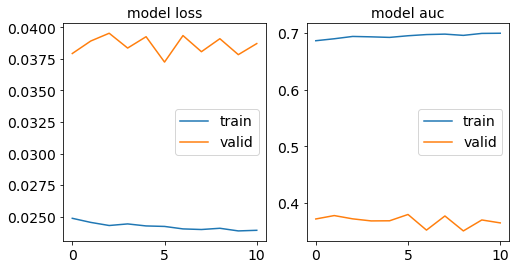

In [13]:
if retrain is True:
    try:
        model.load_weights(os.path.join(wd,"bestmodel_retrain.h5"))
        print("loaded retrained weights")
    except:
        print("retrain did not improve valid performance")
    retrain_benchmarks = {
        "Kleinsitver": amb.reward_fn(model, t1)[0],
        "Listgarten": amb.reward_fn(model, t2)[0],
        "Listgarten_Indel": amb.reward_fn(model, t3)[0],
        "Finkelstein": amb.reward_fn(model, kin_data)[0]
    }
    print(retrain_benchmarks)
    fig, axs = plt.subplots(1,2, figsize=(8,4))
    axs[0].plot(hist.history['loss'], label="train")
    axs[0].plot(hist.history['val_loss'], label="valid")
    axs[0].legend()
    axs[0].set_title('model loss')
    axs[1].plot(hist.history['auc_1'], label="train")
    axs[1].plot(hist.history['val_auc_1'], label="valid")
    axs[1].legend()
    axs[1].set_title('model auc')

In [14]:
layer_dict = {l.name:l for l in model.layers}
k_layer_name = [x for x in layer_dict if x.startswith("kinn_")][0]
kinetic_model = tf.keras.models.Model(
    inputs = model.inputs,
    outputs = layer_dict[k_layer_name].output
)

In [15]:
old_pred_ks = layer_dict[k_layer_name].kinn_header.predict(layer_dict[k_layer_name].mb.blockify_seq_ohe(kin_data[0][:, :, 4:]))

In [16]:
pred_k = kinetic_model.predict(kin_data[0]).flatten()

In [17]:
sess = tf.keras.backend.get_session()
old_pred_k = sess.run(layer_dict[k_layer_name].kinn_body(old_pred_ks)).flatten()

In [18]:
print(
    ss.pearsonr(np.clip(pred_k, -5, -1), kin_data[2]),
    ss.pearsonr(np.clip(old_pred_k, -5, -1), kin_data[2])
)

(0.3850833540151408, 0.0) (0.86813909032177, 0.0)


/mnt/home/zzhang/anaconda3/envs/amber-dev/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

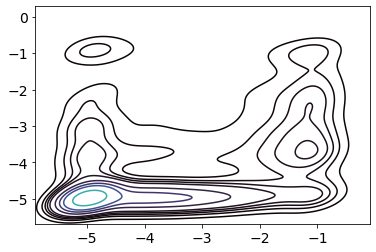

In [19]:
sns.kdeplot(np.clip(pred_k, -5, -1), kin_data[2], fill=False, cmap="mako")

In [20]:
# every single model I trained on in vivo data predicts the last kinetic rate to be -1
# so it must be some differences between in vitro vs in vivo
pred_k

array([-1.6047431 , -0.99999994, -0.99999994, ..., -4.3870873 ,
       -6.9999995 , -1.4302038 ], dtype=float32)

In [21]:
kin_data[2]

array([-1.03242438, -1.15347785, -0.93014961, ..., -5.        ,
       -5.        , -5.        ])

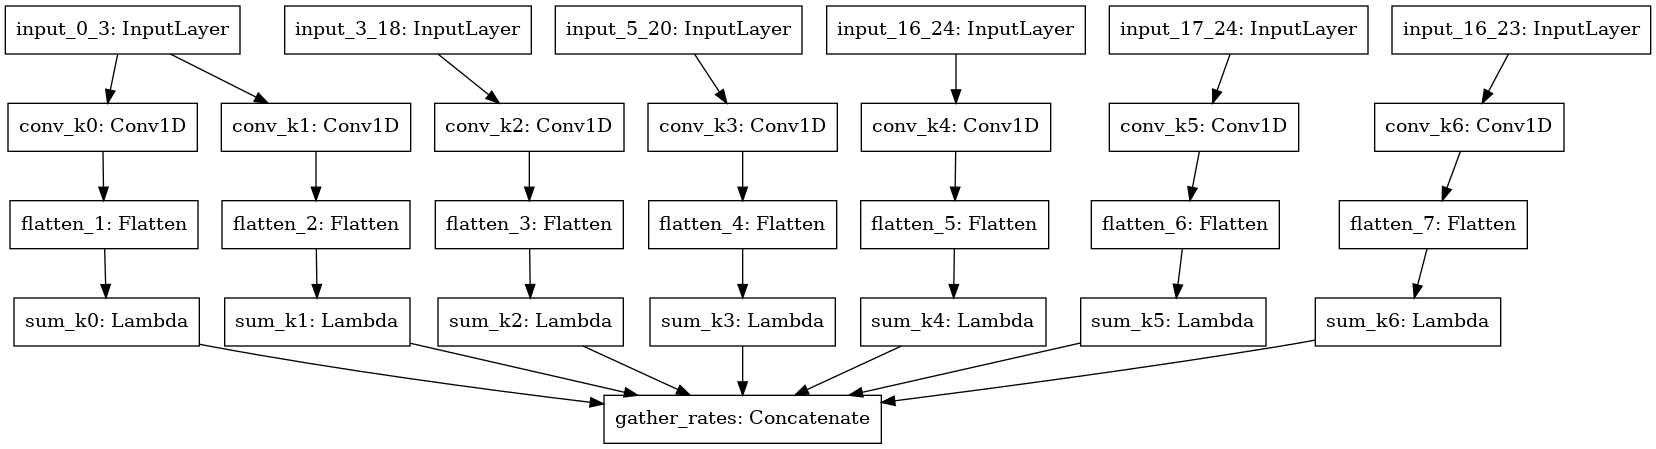

In [22]:
tf.keras.utils.plot_model(layer_dict[k_layer_name].kinn_header)

In [23]:
layer_dict["output_final"].get_weights()

[array([[1.6953037]], dtype=float32), array([3.701895], dtype=float32)]

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Nov 01 2022

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

pandas    : 1.0.3
scipy     : 1.7.3
seaborn   : 0.11.1
numpy     : 1.19.5
tensorflow: 1.15.0
matplotlib: 3.4.3
src       : 0.0.3
h5py      : 2.10.0

Watermark: 2.3.1

